Welcome to the MemoLab's first (?) jupyter notebook!

Today we will be presenting the results of the study `Total Recall`, analyzed using [Quail](http://cdl-quail.readthedocs.io/en/latest/).

# Load in da libraries

Let us begin be importing the two python modules we will be using, `pandas` and `quail`...

In [1]:
import glob # for matching filenames using wildcards
import re # regular expressions
import pandas as pd # a tidyverse esq python data manipulation package
import quail as q # andy's free recall package
import numpy as np # arrary manipulation. because python needs a module for that...

# Read in da data

Next, lets read in the `Total Recall` data and load it into `quail`!

We will read in the data (currently as csv files) using pandas' `read_csv` method.

## Study

First, study.

In [2]:
# get filenames using glob
path = '/Users/kylekurkela/Google Drive/Experiments/TOTAL RECALL/Data/' # where the data is on Kyle's Desktop
filenames = glob.glob(path + "*study*.csv") # filenames selected using wildcards

# read in using pandas
study = pd.concat((pd.read_csv(f) for f in filenames)) # read and concatenate
study = study.sort_values(by=['subjectID', 'Condition', 'listID'])
study.head() # head

,subjectID,sessionID,listID,Word,Arousal,Valence,EmotionCategory,Condition,ExpOnset,SessOnset,ListOnset,resp,resp_time,rt
0,Trs009,1,1,MEDICINE,5.55,5.45,Neutral,2,436.056779,434.829443,1.516699,2@,2.591114,1.074415
1,Trs009,1,1,SOCIETY,5.67,5.28,Neutral,2,440.090144,438.862809,5.550064,2@,6.367106,0.817042
2,Trs009,1,1,SERVER,5.05,5.47,Neutral,2,444.123450,442.896115,9.583370,2@,12.039102,2.455732
3,Trs009,1,1,PUCK,5.16,5.06,Neutral,2,448.156786,446.929450,13.616705,2@,14.839102,1.222396
4,Trs009,1,1,GATE,4.60,5.45,Neutral,2,452.190131,450.962796,17.650051,2@,18.335095,0.685044


## Recall

Second, recall.

In [3]:
# a custom function for reading and extracting useful information from filenames
def read_and_extract_subject_id(f):
    
    # read in file
    tmp = pd.read_csv(f)
    
    # add subjectID column
    p = re.compile('[Tt]rs\d\d\d') # regular expression pattern object
    m = p.search(f) # a match object
    tmp['subjectID'] = m.group() # assign subjectID the matches
    
    # add listID column
    p = re.compile('_\d\d?_') # regular expression pattern object
    m = p.search(f) # a match object
    match = m.group() # actual match
    match = re.search('\d\d?', match).group() # match without the '_'s
    tmp['listID'] = match # assign listID the match
    
    return tmp

In [4]:
# get filenames using glob
path = '/Users/kylekurkela/Google Drive/Experiments/TOTAL RECALL/Data/' # where the data is on Kyle's Desktop
filenames = glob.glob(path + "*test*.csv") # filenames selected using wildcards

# read in using pandas
recall = pd.concat((read_and_extract_subject_id(f) for f in filenames)) # read and concatenate
recall = recall[recall['response'].notnull()] # remove the NaN rows
recall.head() # head

,response,respStart,respReturned,espaceKey,subjectID,listID
0,sponge,2.601766,5.841742,13,trs001,10
1,bully,6.146950,7.307169,13,trs001,10
2,mower,7.778665,11.449556,13,trs001,10
3,hornet,12.417950,13.666265,13,trs001,10
4,gun,14.273735,16.009854,13,trs001,10


# "Humpty, dumpty sat on a wall..."

Next, lets create an `egg`. An `egg` is a specialized data structure used by the quail package.

In [5]:
# Goal: turn `study` data.frames into lists of lists

presented_words = []
presented_word_features = []

# for each subject...
for s in study['subjectID'].unique():
    
    cur_sub = study[study['subjectID'] == s]
    lists = []
    lists_features = []
    
    # for each list...
    for l in cur_sub['listID'].unique():
        
        cur_list = cur_sub[cur_sub['listID'] == l] # current list subset of cur_sub df
        
        words = list(cur_list['Word']) # the words recalled
        
        words = map(str.lower, words) # force lowercase
        
        lists.append(words) # append
        
        lists_features.append(cur_list[['EmotionCategory']].to_dict(orient='records'))
    
    presented_words.append(lists)
    presented_word_features.append(lists_features)

In [6]:
# Goal: turn `recall` data.frames into lists of lists. Note: must match the order of the `study` data.frame.

recalled_words = []

# for each subject...
for s in study['subjectID'].unique():
    
    cur_sub = study[study['subjectID'] == s]
    lists = []
    
    # for each list...
    for l in cur_sub['listID'].unique():
        
        cur_list = recall[np.array(recall['listID'] == str(l)) & np.array(recall['subjectID'] == s)]
        
        lists.append(map(str.lower,list(cur_list['response'])))
        
    recalled_words.append(lists)

In [7]:
# create an egg
egg = q.Egg(pres=presented_words, rec=recalled_words, features=presented_word_features)
egg.info()

Number of subjects: 12
Number of lists per subject: 16
Number of words per list: 16
Date created: Mon Feb 12 15:28:22 2018
Meta data: {}


In [8]:
# presented words
egg.pres.head()

0        1          2         3       4           5   \
Subject List                                                               
0       0     medicine  society     server      puck    gate  typewriter   
        1       brandy   stairs      hinge  lipstick   rifle  windshield   
        2     concrete   statue       cape    saucer     tie     sneaker   
        3      primate     idol     scroll      page    tick        port   
        4     roommate  shingle  biologist   general  tunnel   margarine   

                     6        7         8           9            10  \
Subject List                                                          
0       0        marble      spy      ship      gravel        straw   
        1          crow      hoe  dynamite         egg        wheel   
        2     submarine   pistol  employee      indian     prisoner   
        3          loaf  freckle   dentist     buffalo  screwdriver   
        4         clamp  curtain      fort  politician       poison   

                      11     12      13        14          15  
Subject List                                                   
0       0         priest  noose  mister  tricycle      marker  
        1           drum  tower    hare     lever         box  
        2        boulder   dish   thumb     adult       spine  
        3     flashlight  rider   pluto    binder   carpenter  
        4         relish   heel  beetle   knuckle  protractor

In [9]:
# recalled words
egg.rec.head()

0         1        2           3        4            5   \
Subject List                                                                  
0       0       marker    mister      spy  typewriter     ship     medicine   
        1       brandy       hoe     hare       tower      box        lever   
        2     concrete    statue     cape         tie    spine       indian   
        3       scroll      idol    pluto   carpenter  dentist  screwdriver   
        4      general  roommate  shingle        heel  curtain     fortress   

                      6          7      8      9  ...    11   12   13   14  \
Subject List                                      ...                        
0       0     typewriter     gravel  straw  noose ...   NaN  NaN  NaN  NaN   
        1          rifle       None   None   None ...   NaN  NaN  NaN  NaN   
        2           None       None   None   None ...   NaN  NaN  NaN  NaN   
        3         binder       None   None   None ...   NaN  NaN  NaN  NaN   
        4         tunnel  margerine   None   None ...   NaN  NaN  NaN  NaN   

               15   16   17   18   19   20  
Subject List                                
0       0     NaN  NaN  NaN  NaN  NaN  NaN  
        1     NaN  NaN  NaN  NaN  NaN  NaN  
        2     NaN  NaN  NaN  NaN  NaN  NaN  
        3     NaN  NaN  NaN  NaN  NaN  NaN  
        4     NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 21 columns]

In [10]:
# word features. the only feature we currently have is negative/neutral
egg.features.head()

0   \
Subject List                                     
0       0     {u'EmotionCategory': u'Neutral'}   
        1     {u'EmotionCategory': u'Neutral'}   
        2     {u'EmotionCategory': u'Neutral'}   
        3     {u'EmotionCategory': u'Neutral'}   
        4     {u'EmotionCategory': u'Neutral'}   

                                            1   \
Subject List                                     
0       0     {u'EmotionCategory': u'Neutral'}   
        1     {u'EmotionCategory': u'Neutral'}   
        2     {u'EmotionCategory': u'Neutral'}   
        3     {u'EmotionCategory': u'Neutral'}   
        4     {u'EmotionCategory': u'Neutral'}   

                                            2   \
Subject List                                     
0       0     {u'EmotionCategory': u'Neutral'}   
        1     {u'EmotionCategory': u'Neutral'}   
        2     {u'EmotionCategory': u'Neutral'}   
        3     {u'EmotionCategory': u'Neutral'}   
        4     {u'EmotionCategory': u'Neutral'}   

                                            3   \
Subject List                                     
0       0     {u'EmotionCategory': u'Neutral'}   
        1     {u'EmotionCategory': u'Neutral'}   
        2     {u'EmotionCategory': u'Neutral'}   
        3     {u'EmotionCategory': u'Neutral'}   
        4     {u'EmotionCategory': u'Neutral'}   

                                              4   \
Subject List                                       
0       0       {u'EmotionCategory': u'Neutral'}   
        1     {u'EmotionCategory': u'Emotional'}   
        2       {u'EmotionCategory': u'Neutral'}   
        3     {u'EmotionCategory': u'Emotional'}   
        4       {u'EmotionCategory': u'Neutral'}   

                                            5   \
Subject List                                     
0       0     {u'EmotionCategory': u'Neutral'}   
        1     {u'EmotionCategory': u'Neutral'}   
        2     {u'EmotionCategory': u'Neutral'}   
        3     {u'EmotionCategory': u'Neutral'}   
        4     {u'EmotionCategory': u'Neutral'}   

                                            6   \
Subject List                                     
0       0     {u'EmotionCategory': u'Neutral'}   
        1     {u'EmotionCategory': u'Neutral'}   
        2     {u'EmotionCategory': u'Neutral'}   
        3     {u'EmotionCategory': u'Neutral'}   
        4     {u'EmotionCategory': u'Neutral'}   

                                              7   \
Subject List                                       
0       0     {u'EmotionCategory': u'Emotional'}   
        1       {u'EmotionCategory': u'Neutral'}   
        2     {u'EmotionCategory': u'Emotional'}   
        3       {u'EmotionCategory': u'Neutral'}   
        4       {u'EmotionCategory': u'Neutral'}   

                                              8   \
Subject List                                       
0       0       {u'EmotionCategory': u'Neutral'}   
        1     {u'EmotionCategory': u'Emotional'}   
        2       {u'EmotionCategory': u'Neutral'}   
        3     {u'EmotionCategory': u'Emotional'}   
        4       {u'EmotionCategory': u'Neutral'}   

                                              9   \
Subject List                                       
0       0       {u'EmotionCategory': u'Neutral'}   
        1       {u'EmotionCategory': u'Neutral'}   
        2       {u'EmotionCategory': u'Neutral'}   
        3       {u'EmotionCategory': u'Neutral'}   
        4     {u'EmotionCategory': u'Emotional'}   

                                              10  \
Subject List                                       
0       0       {u'EmotionCategory': u'Neutral'}   
        1       {u'EmotionCategory': u'Neutral'}   
        2     {u'EmotionCategory': u'Emotional'}   
        3       {u'EmotionCategory': u'Neutral'}   
        4     {u'EmotionCategory': u'Emotional'}   

                                            11  \
Subject List                                     
0       0    

# Analysis

Let's run our first analysis! Whoo!

## Recall Accuracy

Recall Accuracy is a piece of cake in Quail...

In [11]:
recall_accuracy = q.analyze(egg, analysis='accuracy')
recall_accuracy.head()

0
Subject List        
0       0     0.5625
        1     0.4375
        2     0.3750
        3     0.4375
        4     0.3750

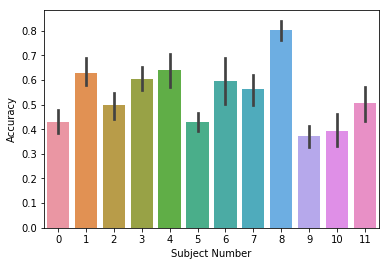

In [12]:
ax = q.plot(recall_accuracy, plot_type='subject', subjname='Subject Number')

## Serial Position Curves

So are serial position curves!!

In [13]:
spc = q.analyze(egg, analysis='spc', listgroup=['2']*8+['8']*8)
spc.head()

0      1      2      3      4      5      6      7      8   \
Subject List                                                                  
0       8     0.750  0.500  0.375  0.375  0.250  0.500  0.250  0.625  0.000   
        2     0.625  0.625  0.375  0.125  0.375  0.250  0.125  0.625  0.375   
1       8     0.875  1.000  0.750  0.625  0.750  0.375  0.500  0.375  0.750   
        2     0.875  0.500  0.750  0.750  0.875  0.875  0.500  0.500  0.750   
2       8     0.750  0.750  0.625  0.500  0.625  0.375  0.250  0.250  0.250   

                 9  ...      11     12     13     14     15   16   17   18  \
Subject List        ...                                                      
0       8     0.375 ...   0.375  0.125  0.375  0.625  0.750  0.0  0.0  0.0   
        2     0.500 ...   0.250  0.500  0.500  0.500  0.875  0.0  0.0  0.0   
1       8     0.625 ...   0.625  0.875  0.625  0.500  0.625  0.0  0.0  0.0   
        2     0.500 ...   0.500  0.500  0.250  0.250  0.625  0.0  0.0  0.0   
2       8     0.375 ...   0.250  0.500  0.500  0.625  1.000  0.0  0.0  0.0   

               19   20  
Subject List            
0       8     0.0  0.0  
        2     0.0  0.0  
1       8     0.0  0.0  
        2     0.0  0.0  
2       8     0.0  0.0  

[5 rows x 21 columns]

/anaconda3/envs/py2716/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


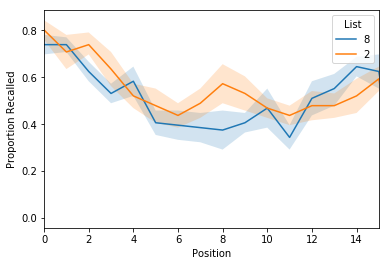

In [14]:
ax = q.plot(spc)

## Probability of First Recall

And wouldn't ya know, calculating the probability of first recall is also a breeze!

In [15]:
pfr = q.analyze(egg, analysis='pfr', listgroup=['2']*8+['8']*8)
pfr.head()

0      1      2      3     4      5    6    7    8    9   \
Subject List                                                                
0       8     0.125  0.125  0.000  0.000  0.00  0.000  0.0  0.0  0.0  0.0   
        2     0.250  0.000  0.125  0.125  0.00  0.000  0.0  0.0  0.0  0.0   
1       8     0.500  0.125  0.000  0.000  0.25  0.000  0.0  0.0  0.0  0.0   
        2     0.250  0.125  0.250  0.000  0.00  0.125  0.0  0.0  0.0  0.0   
2       8     0.125  0.000  0.000  0.125  0.00  0.000  0.0  0.0  0.0  0.0   

             ...      11     12     13     14     15   16   17   18   19   20  
Subject List ...                                                               
0       8    ...   0.000  0.000  0.000  0.375  0.250  0.0  0.0  0.0  0.0  0.0  
        2    ...   0.125  0.000  0.125  0.000  0.250  0.0  0.0  0.0  0.0  0.0  
1       8    ...   0.000  0.125  0.000  0.000  0.000  0.0  0.0  0.0  0.0  0.0  
        2    ...   0.000  0.000  0.000  0.000  0.125  0.0  0.0  0.0  0.0  0.0  
2       8    ...   0.000  0.000  0.000  0.125  0.625  0.0  0.0  0.0  0.0  0.0  

[5 rows x 21 columns]

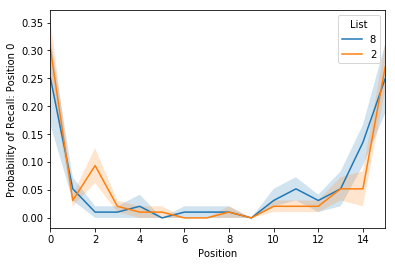

In [16]:
ax = q.plot(pfr)

## Lag-CRP

So, its really that easy isn't it? Just call the same three commands as before and change one of the input arguments? Yup!!

In [17]:
lagcrp = q.analyze(egg, analysis='lagcrp', listgroup=['2']*8+['8']*8)
lagcrp.head()

-16    -15     -14     -13     -12       -11       -10     -9   \
Subject List                                                                   
0       8     0.0  0.000  0.0000  0.0000  0.0000  0.125000  0.316667  0.0250   
        2     0.0  0.000  0.0625  0.0000  0.0000  0.000000  0.031250  0.0625   
1       8     0.0  0.000  0.1250  0.0000  0.0000  0.000000  0.000000  0.0000   
        2     0.0  0.125  0.0000  0.0000  0.0000  0.000000  0.000000  0.0000   
2       8     0.0  0.000  0.0625  0.0625  0.0625  0.166667  0.175000  0.0000   

                   -8        -7  ...         7         8         9        10  \
Subject List                     ...                                           
0       8     0.000000  0.083333 ...   0.000000  0.125000  0.000000  0.06250   
        2     0.020833  0.062500 ...   0.041667  0.000000  0.041667  0.00000   
1       8     0.000000  0.087500 ...   0.081548  0.050000  0.025000  0.03125   
        2     0.000000  0.093750 ...   0.017857  0.080357  0.017857  0.00000   
2       8     0.020833  0.000000 ...   0.041667  0.000000  0.083333  0.00000   

                   11      12     13   14     15   16  
Subject List                                           
0       8     0.18750  0.0000  0.000  0.0  0.000  0.0  
        2     0.06250  0.0625  0.125  0.0  0.000  0.0  
1       8     0.00000  0.0000  0.000  0.0  0.000  0.0  
        2     0.09375  0.0000  0.000  0.0  0.125  0.0  
2       8     0.06250  0.1875  0.000  0.0  0.000  0.0  

[5 rows x 33 columns]

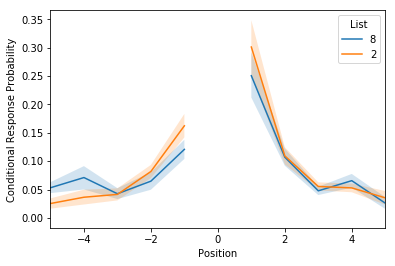

In [18]:
ax = q.plot(lagcrp)

## Temporal clustering

This analysis has got to be more difficult to do, right? Nope!

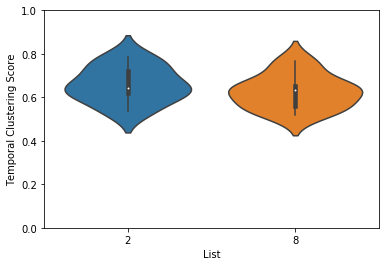

In [19]:
temporal = q.analyze(egg, analysis='temporal', listgroup=['2']*8+['8']*8)
ax = q.plot(temporal, plot_style='violin', ylim=[0,1])

## Memory Fingerprint

Now, for the real fun stuff!

In [20]:
fingerprint = q.analyze(egg, analysis='fingerprint', listgroup=['2']*8+['8']*8)
fingerprint.head()

EmotionCategory
Subject List                 
0       8            0.531058
        2            0.514622
1       8            0.535667
        2            0.556403
2       8            0.538999

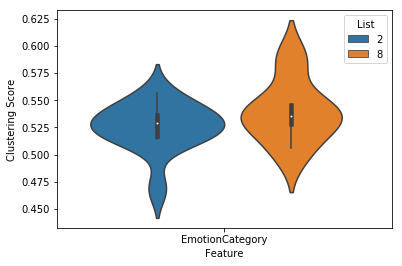

In [21]:
ax = q.plot(fingerprint)